In [172]:

#EDA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, Lasso, LassoLarsCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn import linear_model
from sklearn import metrics
from scipy import stats
from scipy.stats import norm, skew 


test = pd.read_csv('test.csv')
test.head()
test_ID = test['Id']
train=pd.read_csv('train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


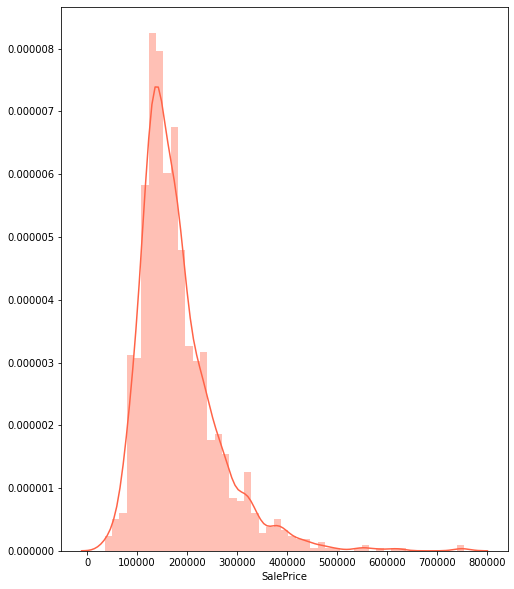

In [173]:
sns.distplot(train.SalePrice,color='tomato')
plt.savefig('train_dis.png')


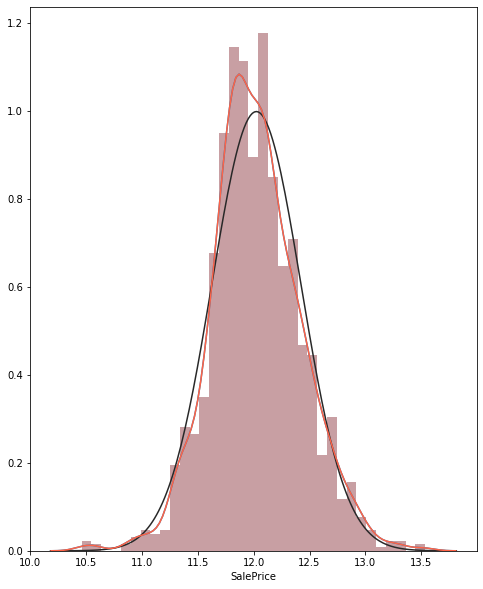

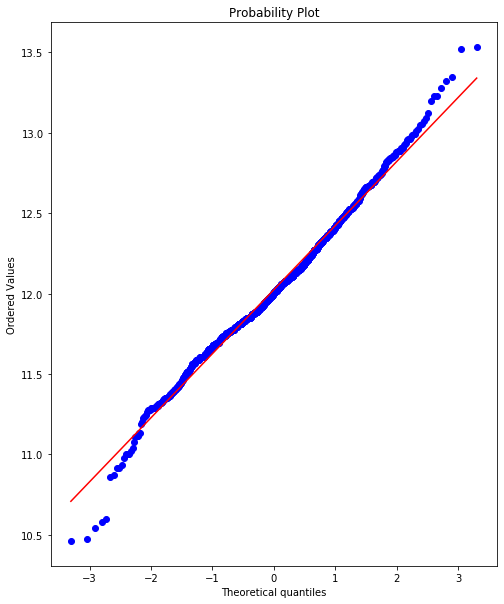

In [174]:
#Dealing with target skewness
#Using log1p to transform the target
train["SalePrice"] = np.log1p(train["SalePrice"])
sns.distplot(train['SalePrice'] , fit=norm);

#Make a plot to see the distribution
sns.distplot(train.SalePrice,color='tomato')

#Get the probability plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

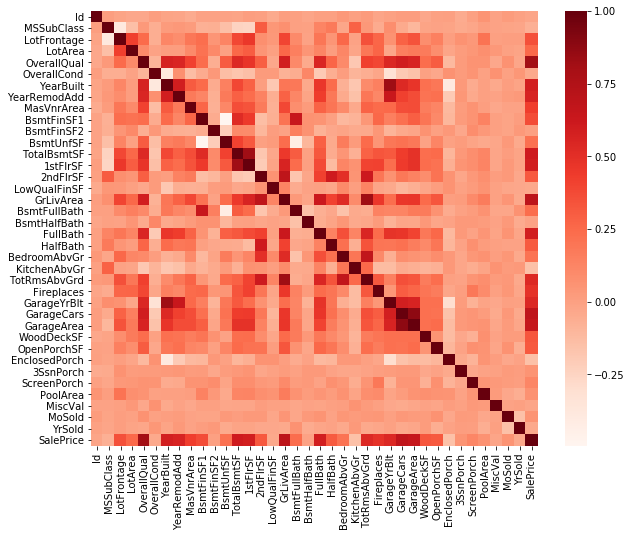

In [175]:
corr=train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,cmap=plt.cm.Reds)
plt.savefig('train_heatmap.png')

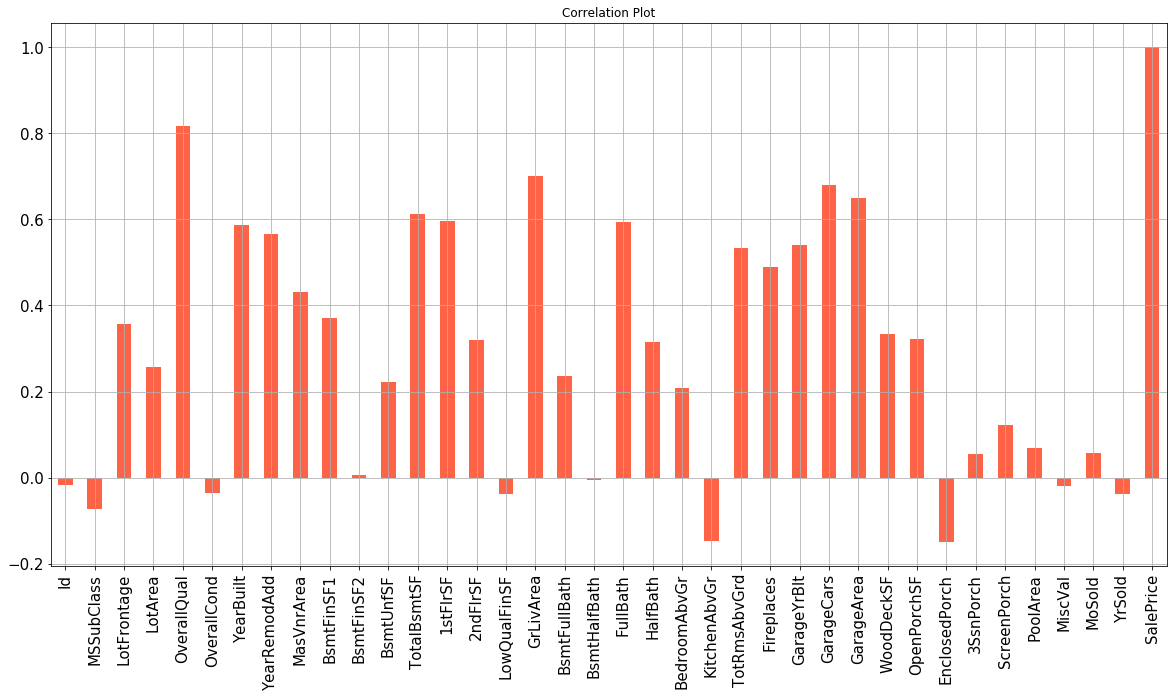

In [176]:
corr['SalePrice'].sort_values()
#Plotting the correlation values with the sales price 
train.corrwith(train.SalePrice).plot.bar(
                                    figsize = (20, 10), title = "Correlation Plot", fontsize = 15,
                                     rot = 90, grid = True, color='tomato')
plt.savefig('train_correlationplot2.png')

In [177]:
#missing data

fulldata = pd.concat((train, test)).reset_index(drop=True)
ntrain= train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
fulldata.drop(['SalePrice'], axis=1, inplace=True)
fulldata_na = fulldata.isnull().sum()
fulldata_na = fulldata_na[fulldata_na>0]
fulldata_na.sort_values(ascending=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageArea         1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
dtype: int64

In [178]:


fulldata['MSZoning'] = fulldata['MSZoning'].fillna('I')   

#Filling with None
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"PoolQC"
           ,'Alley','Fence','MiscFeature','FireplaceQu','MasVnrType','Utilities']:
    fulldata[col] = fulldata[col].fillna('None')
    
#Filling with 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea','BsmtFinSF1','BsmtFinSF2'
           ,'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BsmtUnfSF','TotalBsmtSF'):
    fulldata[col] = fulldata[col].fillna(0)

#Group lotfrontage by neighborhood and filling the missing value by the median
fulldata['LotFrontage'] = fulldata.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
#Filling MSZoning, SaleType, KitchenQual, Exterior2nd, Exterior1st and Electrical with the most frequent value
fulldata['MSZoning'] = fulldata['MSZoning'].fillna(fulldata['MSZoning'].mode()[0])
fulldata['SaleType'] = fulldata['SaleType'].fillna(fulldata['SaleType'].mode()[0])
fulldata['KitchenQual'] = fulldata['KitchenQual'].fillna(fulldata['KitchenQual'].mode()[0])
fulldata['Exterior2nd'] = fulldata['Exterior2nd'].fillna(fulldata['Exterior2nd'].mode()[0])
fulldata['Exterior1st'] = fulldata['Exterior1st'].fillna(fulldata['Exterior1st'].mode()[0])
fulldata['Electrical'] = fulldata['Electrical'].fillna(fulldata['Electrical'].mode()[0])
# Fill the NA in Functional with tpyical
fulldata['Functional'] = fulldata['Functional'].fillna('Typical')
fulldata.shape

#Checking if there is any remaining missing values
fulldata_na = fulldata.isnull().sum()
fulldata_na = fulldata_na[fulldata_na>0]
fulldata_na.sort_values(ascending=False)

Series([], dtype: int64)

In [179]:
#Dealing with feature skewness
#Getting all numerical features
numeric_feats = fulldata.dtypes[fulldata.dtypes != "object"].index

# Check the skewness of all numerical features
skewed_feats = fulldata[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head()

,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065


In [180]:
#Using Box Cox to transform those skewed features
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    fulldata[feat] = boxcox1p(fulldata[feat], lam)


There are 37 skewed numerical features to Box Cox transform


In [181]:
'''
#Drop some features that are not necessary
fulldata = fulldata.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
'''

"\n#Drop some features that are not necessary\nfulldata = fulldata.drop(['Utilities', 'Street', 'PoolQC',], axis=1)\n"

In [182]:
#get dummies
fulldata=pd.get_dummies(fulldata)
fulldata.shape  

(2919, 306)

In [183]:
'''

#Feature Importance
#Random Forest
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=99)
featurenames=train.columns.values
forest.fit(train, y_train) 
importances = forest.feature_importances_
print('R2 for Train)', forest.score( train, y_train ))
feature_importances = pd.DataFrame(importances,
                                   index = train.columns.values,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances
'''

"\n\n#Feature Importance\n#Random Forest\nfrom sklearn.ensemble import RandomForestRegressor\nforest = RandomForestRegressor(random_state=99)\nfeaturenames=train.columns.values\nforest.fit(train, y_train) \nimportances = forest.feature_importances_\nprint('R2 for Train)', forest.score( train, y_train ))\nfeature_importances = pd.DataFrame(importances,\n                                   index = train.columns.values,\n                                    columns=['importance']).sort_values('importance', ascending=False)\nfeature_importances\n"

In [184]:
#Spliting the data into train and test
train = fulldata.iloc[:len(y_train), :]
test = fulldata.iloc[len(y_train):, :]
train.head()


,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,Id,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MSSubClass,MasVnrArea,MiscVal,MoSold,OpenPorchSF,OverallCond,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,Alley_Grvl,Alley_None,Alley_Pave,...,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,Utilities_None
0,11.692623,11.686189,0.0,1.540963,11.170327,0.0,0.730463,0.000000,7.483296,0.000000,0.000000,1.194318,10.506271,1.194318,14.187527,13.698888,0.730463,0.730463,0.730463,19.212182,5.831328,0.0,5.684507,8.059126,0.0,1.194318,5.714669,2.055642,2.440268,0.0,0.0,2.602594,11.692623,0.000000,14.187527,14.187527,14.195323,0,1,0,...,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0
1,12.792276,0.000000,0.0,1.540963,12.062832,0.0,0.000000,0.730463,8.897844,0.000000,0.730463,1.194318,10.062098,1.194318,14.145138,12.792276,0.000000,1.194318,0.730463,19.712205,6.221214,0.0,3.858807,0.000000,0.0,2.055642,0.000000,2.602594,2.259674,0.0,0.0,2.259674,12.792276,9.010206,14.145138,14.145138,14.193765,0,1,0,...,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0
2,11.892039,11.724598,0.0,1.540963,10.200343,0.0,0.730463,0.000000,9.917060,0.000000,0.730463,1.194318,10.775536,1.194318,14.184404,13.832085,0.730463,1.540963,0.730463,20.347241,5.914940,0.0,5.684507,7.646538,0.0,2.750250,5.053371,2.055642,2.440268,0.0,0.0,2.259674,11.892039,0.000000,14.184404,14.185966,14.195323,0,1,0,...,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0
3,12.013683,11.354094,0.0,1.540963,8.274266,0.0,0.730463,0.000000,10.468500,8.797736,0.730463,0.730463,10.918253,1.540963,14.179714,13.711364,0.000000,1.820334,0.730463,19.691553,5.684507,0.0,5.968981,0.000000,0.0,1.194318,4.745132,2.055642,2.440268,0.0,0.0,2.440268,11.354094,0.000000,14.047529,14.135652,14.192207,0,1,0,...,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0
4,12.510588,12.271365,0.0,1.820334,10.971129,0.0,0.730463,0.000000,10.221051,0.000000,0.730463,1.194318,11.627708,1.540963,14.182841,14.480029,0.730463,2.055642,0.730463,21.325160,6.314735,0.0,5.684507,9.391827,0.0,3.128239,6.314735,2.055642,2.602594,0.0,0.0,2.750250,12.510588,8.013884,14.182841,14.182841,14.195323,0,1,0,...,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr

Lasso Score: 0.12493677361224872
Lasso picked 109 variables and eliminated the other 197 variables


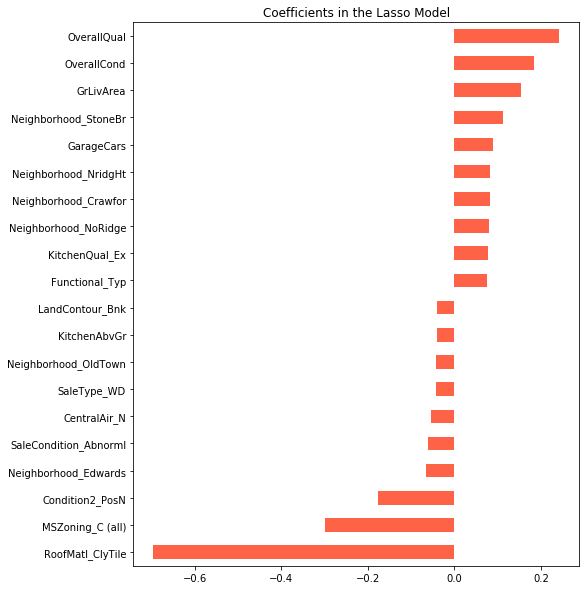

In [186]:
#Modeling
#Define the evaluation
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv =5))
    return(rmse)
#Lasso model
model_lasso = LassoCV(alphas = [1, 0.1, 0.001,0.0005]).fit(train, y_train)
print('Lasso Score:',rmse_cv(model_lasso).mean())
#Do a little bit explore on selecting features
coef_lasso = pd.Series(model_lasso.coef_, index = train.columns)
print("Lasso picked " + str(sum(coef_lasso != 0)) + " variables and eliminated the other " +  str(sum(coef_lasso == 0)) + " variables")
#Plot the coefficient
imp_lasso = pd.concat([coef_lasso.sort_values().head(10), coef_lasso.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_lasso.plot(kind = "barh",color='tomato')
plt.title("Coefficients in the Lasso Model")
plt.savefig('lasso_coe.png')
files.download('lasso_coe.png')

In [0]:
#Lasso prediction
lasso_preds=model_lasso.predict(test)

Ridge Score: 0.1425907376960453
Ridge picked 303 variables and eliminated the other 3 variables


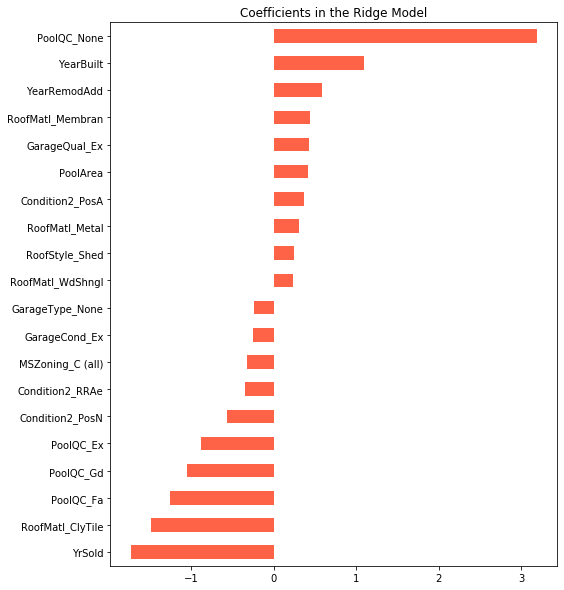

In [188]:
#Ridge model
model_Ridge = Ridge(alpha=0.0005).fit(train, y_train)
print('Ridge Score:',rmse_cv(model_ridge).mean())
#Do a little bit explore on selecting features
coef_ridge = pd.Series(model_ridge.coef_, index = train.columns)
print("Ridge picked " + str(sum(coef_ridge != 0)) + " variables and eliminated the other " +  str(sum(coef_ridge == 0)) + " variables")
imp_ridge = pd.concat([coef_ridge.sort_values().head(10), coef_ridge.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_ridge.plot(kind = "barh",color='tomato')
plt.title("Coefficients in the Ridge Model")
plt.savefig('ridge_coe.png')
files.download('ridge_coe.png')

In [0]:
#Ridge prediction
ridge_preds=model_ridge.predict(test)

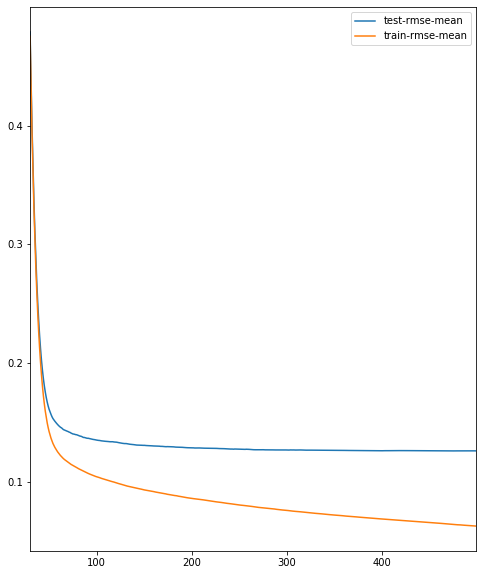

In [190]:
#Xgboost Model
import xgboost as xgb
dtrain = xgb.DMatrix(train,label=y_train)
dtest = xgb.DMatrix(test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [191]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) 
model_xgb.fit(train, y_train)
print('XGBoost Score:',rmse_cv(model_xgb).mean())

[19:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:23:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:23:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:23:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:23:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:23:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Score: 0.12319548857490754


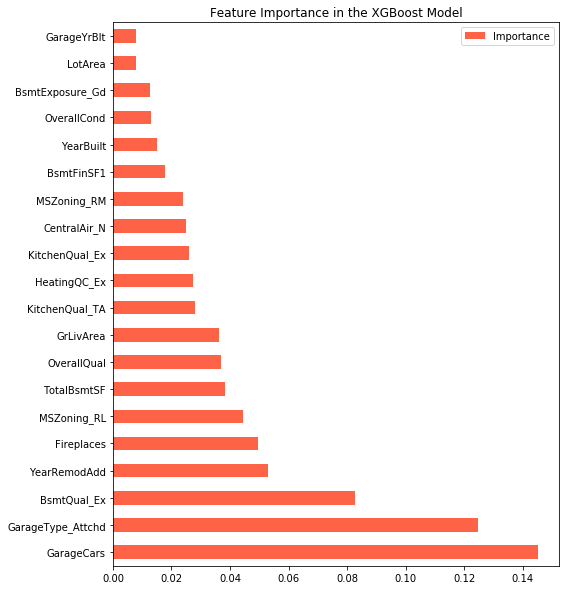

In [192]:
#Plot the coefficient
imp_xgb = pd.DataFrame(model_xgb.feature_importances_ ,columns = ['Importance'],index = train.columns)
imp_xgb= imp_xgb.sort_values(['Importance'], ascending = False)
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_xgb.head(20).plot(kind = "barh",color='tomato')
plt.title("Feature Importance in the XGBoost Model")
plt.savefig('xgb_coe.png')
files.download('xgb_coe.png')

In [0]:
#XGB prediction
XGB_preds=model_xgb.predict(test)

In [194]:
test.head()


,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,Id,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MSSubClass,MasVnrArea,MiscVal,MoSold,OpenPorchSF,OverallCond,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,Alley_Grvl,Alley_None,Alley_Pave,...,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,Utilities_None
1460,11.818680,0.000000,0.0,1.194318,10.105326,7.397498,0.0,0.0,8.780689,0.0,0.000000,0.730463,11.259868,0.730463,14.121376,11.818680,0.000000,13.224069,0.730463,20.479373,6.221214,0.0,3.858807,0.000000,0.000000,2.259674,0.000000,2.259674,2.055642,0.0,7.020909,2.055642,11.775114,7.338607,14.121376,14.121376,14.198437,0,1,0,...,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0
1461,12.943735,0.000000,0.0,1.540963,11.901094,0.000000,0.0,0.0,9.752379,0.0,0.000000,0.730463,9.118181,0.730463,14.116605,12.943735,0.730463,13.226109,0.730463,21.327220,6.244956,0.0,3.858807,6.808145,20.777526,2.259674,4.792130,2.259674,2.259674,0.0,0.000000,2.259674,12.943735,9.672623,14.116605,14.116605,14.198437,0,1,0,...,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0
1462,11.916131,11.151348,0.0,1.540963,11.476685,0.000000,0.0,0.0,7.293500,0.0,0.730463,1.194318,10.179489,1.194318,14.178149,13.551272,0.730463,13.228148,0.730463,21.196905,6.073289,0.0,5.684507,0.000000,0.000000,1.540963,4.697012,2.055642,2.055642,0.0,0.000000,2.259674,11.916131,8.232627,14.178149,14.179714,14.198437,0,1,0,...,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0
1463,11.910125,11.062536,0.0,1.540963,10.749651,0.000000,0.0,0.0,9.207511,0.0,0.730463,1.194318,10.116035,1.194318,14.179714,13.504453,0.730463,13.230186,0.730463,19.865444,6.172972,0.0,5.684507,3.858807,0.000000,2.259674,4.792130,2.259674,2.259674,0.0,0.000000,2.440268,11.910125,9.459637,14.179714,14.179714,14.198437,0,1,0,...,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0
1464,12.833625,0.000000,0.0,1.194318,8.720170,0.000000,0.0,0.0,12.172900,0.0,0.000000,1.194318,10.302477,1.194318,14.170316,12.833625,0.000000,13.232223,0.730463,17.257255,5.093857,0.0,7.020909,0.000000,0.000000,0.730463,6.268453,2.055642,2.602594,0.0,7.397498,2.055642,12.833625,0.000000,14.170316,14.170316,14.198437,0,1,0,...,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0


In [0]:
#ensemble model
preds = 0.4*lasso_preds + 0.4*XGB_preds+0.2*ridge_preds

In [0]:
#Submission
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = preds
sub.to_csv('submission.csv',index=False)

In [198]:
sub.head()

,Id,SalePrice
0,1461,11.702667
1,1462,11.976971
2,1463,12.116501
3,1464,12.182149
4,1465,12.186299


In [0]:
files.download('submission.csv')